In [47]:
%matplotlib inline  
import sys, time, os,shutil,datetime, math
import numpy as np
import matplotlib.pylab as plt
from molSimplify.Classes import globalvars
from molSimplify.Classes import mol3D
from molSimplify.Informatics.autocorrelation import*
from molSimplify.Informatics.misc_descriptors import*
from molSimplify.Informatics.RACassemble import*
from molSimplify.Informatics.graph_analyze import*
from molSimplifyAD.ga_tools import* 
import pickle
from scipy import sparse
import time


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [44]:
def delete_row_csr(mat, i):
    if not isinstance(mat, sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])
    
    return mat

In [33]:
class quickClass:
    def __init__(self,name,descriptor_names,descriptors):
        self.name = name
        self.descriptor_names = descriptor_names
        self.descriptors = descriptors

def write_descriptor_csv_local(list_of_runs,name):
    with open(name +'.csv','w') as f:
        f.write('runs,')
        n_cols = len(list_of_runs[0].descriptor_names)
        
        for i, names in enumerate(list_of_runs[0].descriptor_names):
            if i < (n_cols - 1):
                f.write(names + ',')
            else:
                f.write(names + '\n')
        for runs in list_of_runs:
            f.write(runs.name)
            
            for properties in runs.descriptors:
                    f.write(','+str(properties))
            f.write('\n')
            
def SMILEs_to_liglist(smilesstr,conatoms):
    this_mol = mol3D()
    this_mol.getOBMol(smilesstr,'smistring')
    this_mol.convert2mol3D()
    this_lig  = ligand(mol3D(), [],len(conatoms))
    this_lig.mol = this_mol
    return(this_lig)

In [4]:
liglistM = list()
connectingAtomM = list()
with open("../enum/finalSmiMonodentate.txt",'r') as f:
    for line in f:
        liglistM.append(line.split()[0].replace('#4','#'))
        connectingAtomM.append(0)

liglistB = list()
connectingAtomB = list()
with open("../enum/finalSmiBidentate.txt",'r') as f:
    for line in f:
        liglistB.append(line.split()[0].replace('#4','#'))
        connectingAtomB.append(int(line.split()[2])-1)

connectingAtom = connectingAtomM + connectingAtomB
liglist = liglistM + liglistB

SMILEs_strings_M = liglistM
SMILEs_strings_B = liglistB
SMILEs_strings = liglist

ligsM = [SMILEs_to_liglist(s,[0]) for s in SMILEs_strings_M] 
ligsB = [SMILEs_to_liglist(s,[0]) for s in SMILEs_strings_B] 
ligs = [SMILEs_to_liglist(s,[0]) for s in SMILEs_strings] 

In [133]:
# # homoProj = pickle.load( open( "../enum/homolepMonodentatesProj.p", "r" ) ) 

start_time = time.time()
list_of_runs =[]
list_of_runs =list()

print('Starting Homoleptic Monodentates:')
for metal in ["Cr", "Mn", "Fe", "Co"]: 
    print('Starting with ' + metal)
    for i in range(0,len(liglistM)):
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 

        name = "_".join([metal, 'eq', str(i),'ax', str(i)])
        eq_ligs = 4*[ligsM[i]]
        ax_ligs = 2*[ligsM[i]]
        eq_cons = 4*[[0]]
        ax_cons = 2*[[0]]
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
        list_of_runs.append(quickClass(name, descriptor_names, descriptors))
        new_time = (time.time() - start_time)
print("Homoleptic monodentates took: " + str(new_time) + ' s.')

print('Starting Homoleptic Bidentates:')
for metal in ["Cr", "Mn", "Fe", "Co"]:    
    for i in range(0,len(liglistB)):
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 

        name = "_".join([metal, 'eq', str(i),'ax', str(i)])
        eq_ligs = 2*[ligsB[i]]
        ax_ligs = 1*[ligsB[i]]
        eq_cons = 2*[[0, connectingAtomB[i] ]]
        ax_cons = 1*[[0, connectingAtomB[i] ]]
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
        list_of_runs.append(quickClass(name, descriptor_names, descriptors))
        new_time = (time.time() - start_time)

#         plt.figure(figsize=(12,12))
#         plt.spy(con_mat,precision=0.01, markersize=8) 
        
#         plt.xticks(np.arange(0,20))
#         plt.yticks(np.arange(0,20))
#         plt.grid()
#         plt.title('smiles complex ' + liglistB[i])
#         plt.show()       

write_descriptor_csv(list_of_runs,"RAC_ho")

Starting Homoleptic Monodentates:
Starting with Cr
Starting with Mn
Starting with Fe
Starting with Co
Homoleptic monodentates took: 83.697963953 s.
Starting Homoleptic Bidentates:


In [128]:
# generate racs for ssMono
ssadcProj = pickle.load( open( "../enum/strongsymMonodentatesProj.p", "r" ) )
start_time = time.time()
# list_of_runs1 =list()

## took 9.5 h, 163,620  complexes
# print('Starting Strongly Symmetric ADC Monodentates:')
# for metal in ["Cr", "Mn", "Fe", "Co"]: 
#     print('Starting with ' + metal)
#     for i in range(0, ssadcProj.shape[0]): 
#         metal_mol = mol3D()
#         metal_mol.addAtom(atom3D(metal)) 
        
#         if ssadcProj[i].data[0] == 4:
#             eq = ssadcProj[i].indices[0]
#             ax = ssadcProj[i].indices[1]
#             name = "_".join([metal, 'eq', str(eq),'ax', str(ax)])
#             eq_ligs = 4*[ligsM[eq]]
#             ax_ligs = 2*[ligsM[ax]]
            
#         elif ssadcProj[i].data[0] == 2:
#             eq = ssadcProj[i].indices[1]
#             ax = ssadcProj[i].indices[0]
#             name = "_".join([metal, 'eq', str(eq),'ax', str(ax)])
#             eq_ligs = 4*[ligsM[eq]]
#             ax_ligs = 2*[ligsM[ax]]
        
#         eq_cons = 4*[[0]]
#         ax_cons = 2*[[0]]

#         custom_ligand_dict = {"eq_ligand_list":eq_ligs,
#                               "ax_ligand_list":ax_ligs,
#                               "eq_con_int_list":eq_cons,
#                               "ax_con_int_list":ax_cons}

#         this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
#         con_mat  = this_complex.graph  
#         descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
#         list_of_runs1.append(quickClass(name,descriptor_names,descriptors))
#         new_time = (time.time() - start_time)
# print("strongly symmetric ADC monodentates took: " + str(new_time) + ' s.')
# write_descriptor_csv(list_of_runs1,"RAC_ssadc")

ssadc_b_Proj = pickle.load( open( "../enum/strongsymAdcBidentatesProj.p", "r" ) ) # takes 3.5 h, 59,940 complexes
ssadc_b_Proj = ssadc_b_Proj.tocsr()
print(ssadc_b_Proj.getrow(0))
print(ssadc_b_Proj.get_shape())
list_of_runs2 =list()
print('Starting Strongly Symmetric ADC Bidentates:')
for metal in ["Cr", "Mn", "Fe", "Co"]:  
    print('Starting with ' + metal)
    for i in range(0, ssadc_b_Proj.shape[0]):  #ssadc_b_Proj.shape[0]
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 
        
        if ssadc_b_Proj[i].indices[1] > 404: # if the first is in the second half of the list, it is a bidentate and goes eq
            eq = ssadc_b_Proj[i].indices[1]
            ax = ssadc_b_Proj[i].indices[0]
        else:
            eq = ssadc_b_Proj[i].indices[0]
            ax = ssadc_b_Proj[i].indices[1]
        
        name = "_".join([metal, 'eq', str(eq),'ax', str(ax)])
        eq_ligs = 2*[ligs[eq]]
        ax_ligs = 2*[ligs[ax]]
        
        eq_cons = 2*[[connectingAtom[ax], connectingAtom[eq] ]]
        ax_cons = 2*[[connectingAtom[ax]]]
        
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
        list_of_runs2.append(quickClass(name, descriptor_names, descriptors))
        new_time = (time.time() - start_time)
        
#         plt.figure(figsize=(5,5))
#         plt.spy(con_mat,precision=0.01, markersize=8) 
        
#         plt.xticks(np.arange(0,20))
#         plt.yticks(np.arange(0,20))
#         plt.grid()
#         plt.title('smiles complex. Eq:' + liglist[eq] + ' Ax:' + liglist[ax])
#         plt.show()


print("strongly symmetric ADC Bidentates took: " + str(new_time) + ' s.')
write_descriptor_csv(list_of_runs2,"RAC_ssadc_b")


ssac_b_Proj = pickle.load( open( "../enum/strongsymAcBidentatesProj.p", "r" ) ) # takes 4.5 h, 21,756 complexes
ssac_b_Proj = ssac_b_Proj.tocsr()
print(ssac_b_Proj.get_shape())
print(ssac_b_Proj.getrow(0))
list_of_runs3 =list()
print('Starting Strongly Symmetric AC Bidentates:')
for metal in ["Cr", "Mn", "Fe", "Co"]:  
    print('Starting with ' + metal)
    for i in range(0, ssac_b_Proj.shape[0]):  #ssac_b_Proj.shape[0]
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 
        
        if ssac_b_Proj[i].indices[1] == 2: # if the first is in the second half of the list, it is a bidentate and goes eq
            eq = ssac_b_Proj[i].indices[1]
            ax = ssac_b_Proj[i].indices[0]
        else:
            eq = ssac_b_Proj[i].indices[0]
            ax = ssac_b_Proj[i].indices[1]
        
        name = "_".join([metal, 'eq', str(eq),'ax', str(ax)])
        eq_ligs = 2*[ligsB[eq]]
        ax_ligs = 1*[ligsB[ax]]
        
        eq_cons = 2*[[0, connectingAtomB[eq] ]]
        ax_cons = 1*[[0, connectingAtomB[ax] ]]
        
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
        list_of_runs3.append(quickClass(name, descriptor_names, descriptors))
        new_time = (time.time() - start_time)
        
#         plt.figure(figsize=(5,5))
#         plt.spy(con_mat,precision=0.01, markersize=8) 
        
#         plt.xticks(np.arange(0,20))
#         plt.yticks(np.arange(0,20))
#         plt.grid()
#         plt.title('smiles complex. Eq:' + liglistB[eq] + ' Ax:' + liglistB[ax])
#         plt.show()


print("strongly symmetric ADC Bidentates took: " + str(new_time) + ' s.')

write_descriptor_csv(list_of_runs3,"RAC_ssac_b")


  (0, 404)	1.0
  (0, 552)	1.0
(59940, 553)
Starting Strongly Symmetric ADC Bidentates:
Starting with Cr
Starting with Mn
Starting with Fe
Starting with Co
Homoleptic strongly symmetric ADC Bidentates took: 11984.634836 s.
(21756, 148)
  (0, 146)	2.0
  (0, 147)	1.0
Starting Strongly Symmetric AC Bidentates:
Starting with Cr
Starting with Mn
Starting with Fe
Starting with Co
Homoleptic strongly symmetric ADC Bidentates took: 16366.017081 s.


In [250]:
# generate racs for foMono (five-one)
list_of_runs =[]
start_time = time.time()
list_of_runs =list()
for metal in ["Cr", "Mn", "Fe", "Co"]: 
    for i in range(0, foProj.shape[0]): # 
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 
        
        if foProj[i].data[0] == 5:
            f = foProj[i].indices[0]
            o = foProj[i].indices[1]
            name = "_".join([metal, 'f', str(f),'o', str(o)])
            eq_ligs = 4*[ligs[f]]
            ax_ligs = [ligs[f],ligs[o]]
            
        elif foProj[i].data[0] == 1:
            f = foProj[i].indices[1]
            o = foProj[i].indices[0]
            name = "_".join([metal, 'f', str(f),'o', str(o)])
            eq_ligs = 4*[ligs[f]]
            ax_ligs = [ligs[o],ligs[f]]
        
        eq_cons = 4*[[0]]
        ax_cons = 2*[[0]]
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
        list_of_runs.append(quickClass(name,descriptor_names,descriptors))
        new_time = (time.time() - start_time)

    #     print("--- %s seconds ---" % new_time)
    #     print(i)

    #     plt.spy(con_mat,precision=0.01, markersize=15)    
    #     plt.title('smiles complex ' + liglist[i])
    #     plt.show()
        
print("--- %s seconds ---" % new_time)
# --- 34494.538744 seconds --- = 9.58 h

write_descriptor_csv(list_of_runs,"foRACs")

--- 34391.267837 seconds ---


In [36]:
# # generate racs for ftMono (four-two)
start_time = time.time()
# list_of_runs =list()
# ftProj = pickle.load( open( "../enum/fourtwosymMonodentatesProj.p", "r" ) )

# for metal in ["Cr", "Mn", "Fe", "Co"]: 
#     for i in range(0, 1): # ftProj.shape[0]
#         print('Starting with ' + metal)
#         metal_mol = mol3D()
#         metal_mol.addAtom(atom3D(metal)) 
        
#         if ftProj[i].data[0] == 4:
#             f = ftProj[i].indices[0]
#             t = ftProj[i].indices[1]
              
#         elif ftProj[i].data[0] == 2:
#             f = ftProj[i].indices[1]
#             t = ftProj[i].indices[0]

#         name = "_".join([metal, 'f', str(f),'t', str(t)])
#         eq_ligs = 2*[ligsM[f],ligsM[t]]
#         ax_ligs = 2*[ligsM[f]]
            
#         eq_cons = 4*[[0]]
#         ax_cons = 2*[[0]]
        
#         custom_ligand_dict = {"eq_ligand_list":eq_ligs,
#                               "ax_ligand_list":ax_ligs,
#                               "eq_con_int_list":eq_cons,
#                               "ax_con_int_list":ax_cons}

#         this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
#         con_mat  = this_complex.graph  
#         descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
#         list_of_runs.append(quickClass(name,descriptor_names,descriptors))
#         new_time = (time.time() - start_time)

# print("FT monodentates took: " + str(new_time) + ' s.')
# write_descriptor_csv(list_of_runs,"RAC_ft")

# # --- 35126.2804871 seconds --- = 9.75 h




ft_b_Proj = pickle.load( open( "../enum/fourtwosymBidentatesProj.p", "r" ) ) # takes 72 min h, 
ft_b_Proj = ft_b_Proj.tocsr()
print(ft_b_Proj.getrow(0))
print(ft_b_Proj.get_shape())
list_of_runs2 =list()
print('Starting Four Two Bidentates:')
for metal in ["Cr", "Mn", "Fe", "Co"]:  
    print('Starting with ' + metal)
    for i in range(0, ft_b_Proj.shape[0]):  #ft_b_Proj.shape[0]
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 
        
        if int(ft_b_Proj[i].data[1]) == 2: # 
            f = ft_b_Proj[i].indices[1]
            t = ft_b_Proj[i].indices[0]
        else:
            f = ft_b_Proj[i].indices[0]
            t = ft_b_Proj[i].indices[1]
        
        name = "_".join([metal, 'four', str(f),'two', str(t)])
        eq_ligs = [ligsB[f],ligsB[t]]
        ax_ligs = [ligsB[f]]
        
        eq_cons = [[0, connectingAtomB[f]],[0, connectingAtomB[t] ]]
        ax_cons = [[0, connectingAtomB[f]]]
        
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}
        
        this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
        list_of_runs2.append(quickClass(name, descriptor_names, descriptors))
        new_time = (time.time() - start_time)
        
#         plt.figure(figsize=(5,5))
#         plt.spy(con_mat,precision=0.01, markersize=8) 
        
#         plt.xticks(np.arange(0,20))
#         plt.yticks(np.arange(0,20))
#         plt.grid()
#         plt.title('smiles complex. eq:' + liglistB[eq] + ' Ax:' + liglistB[ax])
#         plt.show()


print("Four Two Bidentates took: " + str(new_time) + ' s.')
write_descriptor_csv_local(list_of_runs2,"RAC_ft_b")

  (0, 146)	2.0
  (0, 147)	1.0
(21756, 148)
Starting Four Two Bidentates:
Starting with Cr
Starting with Mn
Starting with Fe
Starting with Co
Four Two Bidentates took: 4371.12728119 s.


  (0, 10)	4.0
  (0, 402)	1.0
  (0, 404)	1.0
(81406, 405)
Starting with Cr


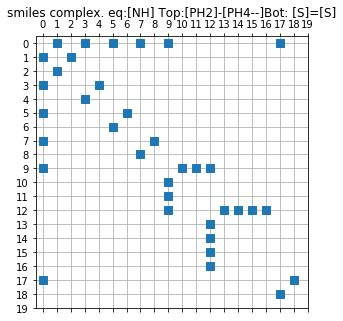

Starting with Mn


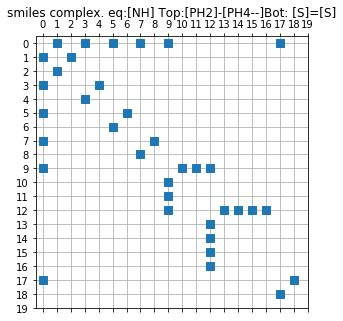

Starting with Fe


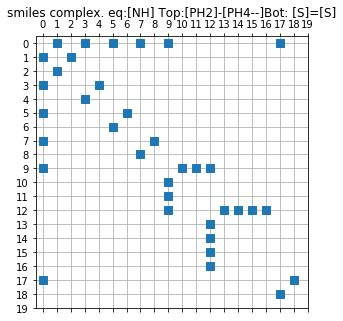

Starting with Co


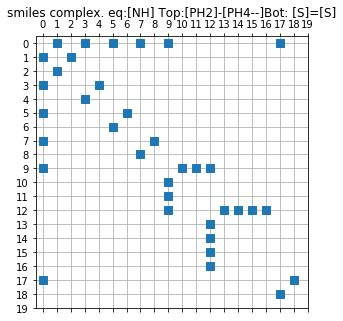

WS monodentates took: 0.675580024719 s.


In [64]:
# # generate racs for wsMono
start_time = time.time()
list_of_runs = list()
wsProj = pickle.load( open( "../enum/weaksymMonodentatesProj/weaksymMonodentatesProj_010.p2", "r" ) )
wsProj = delete_row_csr(wsProj, 0)
print(wsProj.getrow(1))
print(wsProj.get_shape())
for metal in ["Cr", "Mn", "Fe", "Co"]: 
    for i in range(100, 101): # wsProj.shape[0]
        print('Starting with ' + metal)
        metal_mol = mol3D()
        metal_mol.addAtom(atom3D(metal)) 
        
        if int(wsProj[i].data[0]) == 4:
            eq = wsProj[i].indices[0]
            top = wsProj[i].indices[1]
            bot = wsProj[i].indices[2]
              
        elif int(wsProj[i].data[1]) == 4:
            eq = wsProj[i].indices[1]
            top = wsProj[i].indices[0]
            bot = wsProj[i].indices[2]
        
        elif int(wsProj[i].data[2]) == 4:
            eq = wsProj[i].indices[2]
            top = wsProj[i].indices[1]
            bot = wsProj[i].indices[0]

        name = "_".join([metal, 'top', str(top),'bottom', str(bot), 'eq', str(eq)])
        eq_ligs = 4*[ligsM[eq]]
        ax_ligs = [ligsM[top], ligsM[bot]]
            
        eq_cons = 4*[[0]]
        ax_cons = 2*[[0]]
        
        custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                              "ax_ligand_list":ax_ligs,
                              "eq_con_int_list":eq_cons,
                              "ax_con_int_list":ax_cons}

        this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
        con_mat  = this_complex.graph  
        descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
        list_of_runs.append(quickClass(name,descriptor_names,descriptors))
        new_time = (time.time() - start_time)
        
#         plt.figure(figsize=(5,5))
#         plt.spy(con_mat,precision=0.01, markersize=8) 
        
#         plt.xticks(np.arange(0,20))
#         plt.yticks(np.arange(0,20))
#         plt.grid()
#         plt.title('smiles complex. eq:' + liglistM[eq] + ' Top:' + liglistM[top] + 'Bot: ' + liglistM[bot])
#         plt.show()

print("WS monodentates took: " + str(new_time) + ' s.')
write_descriptor_csv_local(list_of_runs,"RAC_ws")



# ft_b_Proj = pickle.load( open( "../enum/fourtwosymBidentatesProj.p", "r" ) ) # takes 72 min h, 
# ft_b_Proj = ft_b_Proj.tocsr()
# print(ft_b_Proj.getrow(0))
# print(ft_b_Proj.get_shape())
# list_of_runs2 =list()
# print('Starting Four Two Bidentates:')
# for metal in ["Cr", "Mn", "Fe", "Co"]:  
#     print('Starting with ' + metal)
#     for i in range(0, ft_b_Proj.shape[0]):  #ft_b_Proj.shape[0]
#         metal_mol = mol3D()
#         metal_mol.addAtom(atom3D(metal)) 
        
#         if int(ft_b_Proj[i].data[1]) == 2: # 
#             f = ft_b_Proj[i].indices[1]
#             t = ft_b_Proj[i].indices[0]
#         else:
#             f = ft_b_Proj[i].indices[0]
#             t = ft_b_Proj[i].indices[1]
        
#         name = "_".join([metal, 'four', str(f),'two', str(t)])
#         eq_ligs = [ligsB[f],ligsB[t]]
#         ax_ligs = [ligsB[f]]
        
#         eq_cons = [[0, connectingAtomB[f]],[0, connectingAtomB[t] ]]
#         ax_cons = [[0, connectingAtomB[f]]]
        
#         custom_ligand_dict = {"eq_ligand_list":eq_ligs,
#                               "ax_ligand_list":ax_ligs,
#                               "eq_con_int_list":eq_cons,
#                               "ax_con_int_list":ax_cons}
        
#         this_complex = assemble_connectivity_from_parts(metal_mol, custom_ligand_dict)
#         con_mat  = this_complex.graph  
#         descriptor_names, descriptors = get_descriptor_vector(this_complex, custom_ligand_dict)
#         list_of_runs2.append(quickClass(name, descriptor_names, descriptors))
#         new_time = (time.time() - start_time)
        
# #         plt.figure(figsize=(5,5))
# #         plt.spy(con_mat,precision=0.01, markersize=8) 
        
# #         plt.xticks(np.arange(0,20))
# #         plt.yticks(np.arange(0,20))
# #         plt.grid()
# #         plt.title('smiles complex. eq:' + liglistB[eq] + ' Ax:' + liglistB[ax])
# #         plt.show()


# print("Four Two Bidentates took: " + str(new_time) + ' s.')
# write_descriptor_csv_local(list_of_runs2,"RAC_ft_b")